In [4]:
import gdown
import pims
import torch as tr
import numpy as np
import matplotlib.pyplot as plt

from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root

def dwd_video_if_needed() -> str:
    """download the video in the resources dir if not exist and return the path"""
    video_path = get_project_root() / "resources/testVideo.mp4"
    if not video_path.exists():
        video_path.parent.mkdir(exist_ok=True, parents=True)
        gdown.download("https://drive.google.com/uc?id=158U-W-Gal6eXxYtS1ca1DAAxHvknqwAk", f"{video_path}")
    return f"{video_path}"


In [5]:

"""setup all representations we want to use, including one representation per device"""
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict: dict[str, dict] = {
    "opticalflow raft": {"type": "optical-flow", "name": "raft", "dependencies": [],
                         "parameters": {"inference_height": 360, "inference_width": 640,
                                        "small": False, "mixed_precision": False, "iters": 20},
                         "vre_parameters": {"device": device}},
    "depth odoflow (raft)": {"type": "depth", "name": "odo-flow", "dependencies": ["opticalflow raft"],
                             "parameters": {"linear_ang_vel_correction": True, "focus_correction": True,
                                            "cosine_correction_scipy": False, "cosine_correction_gd": True,
                                            "sensor_fov": 75, "sensor_width": 3840, "sensor_height": 2160,
                                            "min_depth_meters": 0, "max_depth_meters": 400},
                             "vre_parameters": {"velocities_path": "DJI_0956_velocities.npz"}},
}

video = pims.Video(dwd_video_if_needed())
print(video)
batch_sizes = [1]
start_frame = 1000
end_frame = start_frame + 1

representations = build_representations_from_cfg(all_representations_dict)
print(representations)

# run vre_setup (inference mode)
r = representations["depth odoflow (raft)"]
r.vre_setup(video, **all_representations_dict["depth odoflow (raft)"]["vre_parameters"])
flow_r = representations["opticalflow raft"]
flow_r.vre_setup(video, **all_representations_dict["opticalflow raft"]["vre_parameters"])

[20231113 14:31:01-VRE-INFO] Building 'optical-flow'/'opticalflow raft' (__init__.py:build_representation_from_cfg:93)


[20231113 14:31:01-VRE-INFO] Building 'depth'/'depth odoflow (raft)' (__init__.py:build_representation_from_cfg:93)


<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: /home/mihai/code/video-representations-extractor/resources/testVideo.mp4
Duration: 301.001 seconds
Frame rate: 29.970 fps
Length: 9021 frames
Frame Shape: (720, 1280, 3)



[20231113 14:31:08-VRE-INFO] Loading velocities from '/home/mihai/code/video-representations-extractor/weights/DJI_0956_velocities.npz' (depth_odo_flow.py:vre_setup:45)


{'opticalflow raft': [FlowRaft VRE Representation: opticalflow raft], 'depth odoflow (raft)': [DepthOdoFlow VRE Representation: depth odoflow (raft)]}


## Run the representations for two particular frame

3392


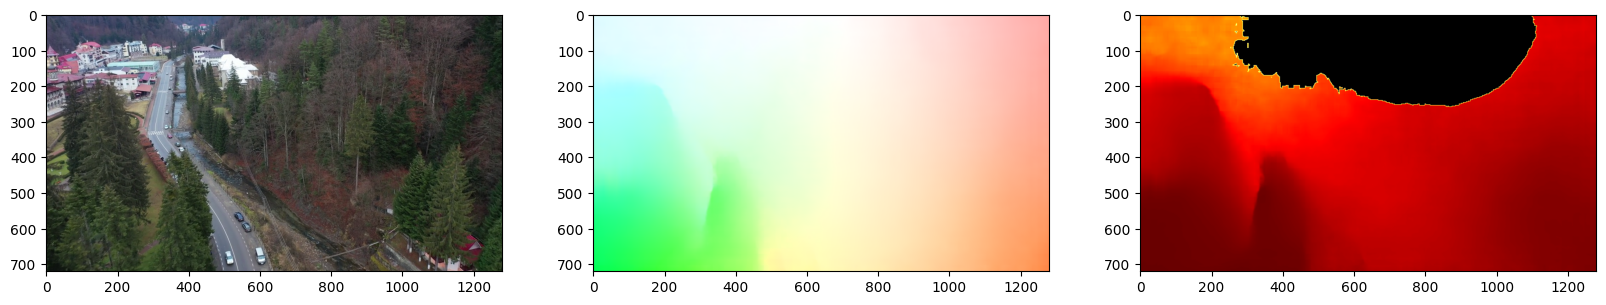

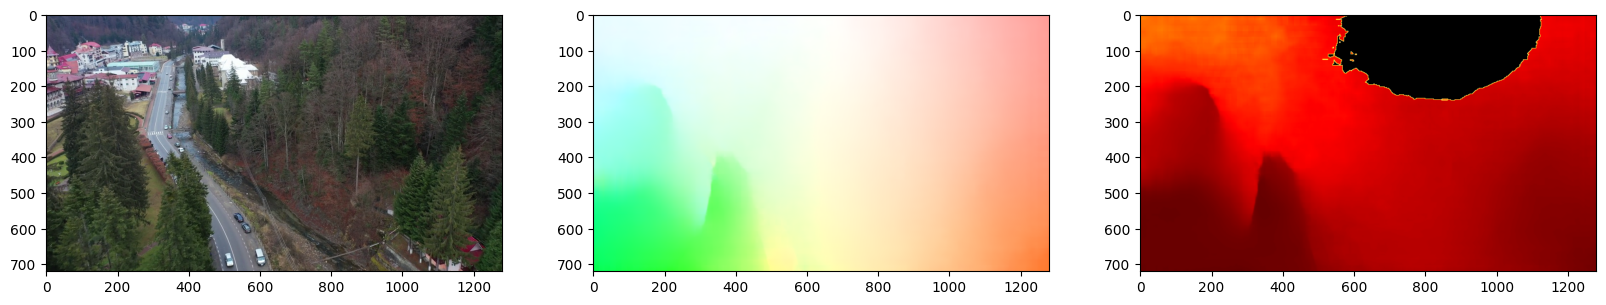

In [6]:
np.random.seed(43)
start = np.random.randint(0, len(video) - 1)
print(start)
mb = 2
slc = slice(start, start + mb)

frames = np.array(video[slc])
right_frames = np.array(video[slc.start + 1: slc.stop + 1])
y_flow = flow_r.make(frames, right_frames)
y_flow_img = flow_r.make_images(frames, y_flow)
y_odoflow = r.make(frames, lin_vel=r.camera_info.linear_velocity[slc],
                   ang_vel=r.camera_info.angular_velocity[slc], flows=y_flow)
y_odowflow_img = r.make_images(frames, y_odoflow)
for i in range(len(y_odowflow_img)):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(frames[i])
    ax[1].imshow(y_flow_img[i])
    ax[2].imshow(y_odowflow_img[i])
    plt.show()
